# Safer Roadways for Virginia

*An ML4VA project at the University of Virginia, Fall 2019*

Tyra Krehbiel (tik5eh) &
Aisha Singh (as9jf)


# Step 1. Setup and Big-Picture

In [0]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import sklearn.linear_model
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ML4VA"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Step 2: Get the Data

In [4]:
accidents = pd.read_csv("Virginia_Crashes_official.csv")
accidents.head()

,Unnamed: 0,X,Y,OBJECTID,A_Crash,A_People,B_Crash,B_People,Collision_Type,Crash_Dt,Crash_Military_Tm,Crash_Severity,Crash_Year,C_Crash,C_People,Physical_Juris,VDOT_District,LATITUDE,Plan_District,DIAGRAM,Document_Nbr,Driverage,Drivergen,Driverinjurytype,Driver_Action_Type_Cd,District,FAC,Fatal_Crashes,FUN,LONGITUDE,LOCAL_CASE_CD,Mpo_Name,Passage,Passgen,Passinjurytype,Pdo_Crash,Pedage,Pedgen,Pedinjurytype,Persons_Killed,VSP_Used,Planning,Rns_Mp,Roadway_Surface_Cond,Route_Or_Street_Nm,Rte_Nm,Vehiclenumber,Vehicle_Body_Type_Cd,Weather_Condition
0,2430,-77.069382,38.853158,5431,0,0,1,1,12. Ped,2017-09-20T00:00:00.000Z,1702,B.Visible Injury,2017,0,0,0.Arlington,9.Northern Virginia,38.85315,Northern Virginia,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,172635325,86,Male,PDO,11. Did Not Have Right-of-Way,9,"0.Two-way, non-divided",0,I.Urban Collector,-77.06938,2017-09200201,Northern Virginia Portion of The Metropolitan ...,NaN,NaN,NaN,0,12,Female,B,0,7,Northern Virginia,0.236454,1. Dry,23RD ST S,R-VA000SC06708WB,1,1. Passenger car,1. No Adverse Condition (Clear/Cloudy)
1,2521,-78.182833,38.910238,5522,0,0,1,1,12. Ped,2018-12-03T00:00:00.000Z,1756,B.Visible Injury,2018,0,0,112.Front Royal,8.Staunton,38.91023,Northern Shenandoah Valley,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,183385261,50,Female,PDO,1. No Improper Action,8,"0.Two-way, non-divided",0,E.Urban Other Principal Arterials; Connecting ...,-78.18283,18120105,NaN,NaN,NaN,NaN,0,68,Female,B,0,2,Northern Shenandoah Valley,29.686989,1. Dry,865 JOHN MARSHALL HWY,R-VA SR00055EB,1,22. Truck - Sport Utility Vehicle (SUV),1. No Adverse Condition (Clear/Cloudy)
2,3565,-77.068982,38.844698,2566,0,0,1,1,12. Ped,2019-04-03T00:00:00.000Z,730,B.Visible Injury,2019,0,0,0.Arlington,9.Northern Virginia,38.84469,Northern Virginia,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,190935078,23,Female,PDO,20. Disregarded Officer or Flagger,9,"1.Divided, no control of access",0,E.Urban Other Principal Arterials; Connecting ...,-77.06898,2019-04030044,Northern Virginia Portion of The Metropolitan ...,NaN,NaN,NaN,0,NaN,Male,B,0,7,Northern Virginia,8.143990,1. Dry,2900 SOUTH GLEBE ROAD,R-VA SR00120EB,1,1. Passenger car,1. No Adverse Condition (Clear/Cloudy)
3,3566,-76.250002,36.861097,2567,0,0,0,0,12. Ped,2013-04-11T00:00:00.000Z,2025,C.Nonvisible Injury,2013,1,1,122.Norfolk,5.Hampton Roads,36.86109,Hampton Roads,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,131930109,NaN,Not Provided,PDO,1. No Improper Action,5,"0.Two-way, non-divided",0,H.Urban Minor Arterial,-76.25000,P13041100628,Hampton Roads Transportation Planning Organiza...,NaN,NaN,NaN,0,53,Male,C,0,5,Hampton Roads,0.574902,1. Dry,2135 BALLENTINE BLVD,R-VA122UR08573SB,1,2. Truck - Pick-up/Passenger Truck,1. No Adverse Condition (Clear/Cloudy)
4,3567,-77.439182,37.544117,2568,0,0,0,0,12. Ped,2013-01-04T00:00:00.000Z,1253,C.Nonvisible Injury,2013,1,1,127.Richmond,4.Richmond,37.54411,Richmond Regional,http://rns/APP/Images/CrashDiagramProxy.aspx?d...,130940000,NaN,Not Provided,PDO,34. Hit and Run,4,"1.Divided, no control of access",0,E.Urban Other Principal Arterials; Connecting ...,-77.43918,201301040235,Richmond Transportation Planning Organization,NaN,NaN,NaN,0,23,Male,C,0,1,Richmond Regional,166.058996,1. Dry,N 3RD ST W BROAD ST,R-VA US00250WB,1,1. Passenger car,1. No Adverse Condition (Clear/Cloudy)


In [5]:
accidents["Collision_Type"].value_counts()

12. Ped                              9666
2. Angle                              405
16. Other                             248
1. Rear End                           190
3. Head On                            119
4. Sideswipe - Same Direction         118
9. Fixed Object - Off Road             93
15. Backed Into                        62
8. Non-Collision                       30
5. Sideswipe - Opposite Direction      24
13. Bicyclist                          19
6. Fixed Object in Road                15
11. Other Animal                        4
10. Deer                                2
7. Train                                2
14. Motorcyclist                        1
Not Provided                            1
Name: Collision_Type, dtype: int64

In [6]:
accidents["Pedinjurytype"].value_counts()

B                  5646
A                  2646
C                  1577
K                   622
B,B                 163
A,A                  68
A,B                  46
C,C                  45
B,C                  37
C,B                  18
A,C                  17
B,B,B                15
K,A                  15
B,A                  13
A,A,A                 8
PDO                   7
K,B                   6
C,C,C                 5
C,A                   5
K,K                   5
A,A,B                 3
A,K                   3
B,B,C                 2
K,A,A                 2
A,B,B                 2
B,B,B,B,B             2
B,A,A                 1
B,K,K                 1
K,K,K                 1
B,B,B,B,B,B           1
K,C,C                 1
B,A,B,B,B,B,B,B       1
A,K,A,B               1
A,B,C                 1
B,B,B,B               1
C,B,B                 1
B,C,C,C               1
B,A,C                 1
A,A,K                 1
A,A,A,B,B             1
A,A,B,C               1
K,C             

In [7]:
# remove unnecessary attributes
# X = longitude, Y = latitude
accidents = accidents.drop(["OBJECTID", "VDOT_District","Plan_District",
                            "Document_Nbr","LOCAL_CASE_CD","Mpo_Name", 
                            "A_Crash", "A_People", "B_Crash", "B_People", 
                            "C_Crash", "C_People", "DIAGRAM", "Persons_Killed",
                            "LONGITUDE", "LATITUDE","Rns_Mp", "Passage",
                            "Physical_Juris", "Pdo_Crash", "Unnamed: 0",
                            "Driverage","Drivergen","Driverinjurytype", 
                            "Driver_Action_Type_Cd", "FAC", "FUN", "Passgen", 
                            "Route_Or_Street_Nm", "Passinjurytype", "Planning", 
                            "Vehiclenumber", "Roadway_Surface_Cond", "VSP_Used",
                            "Vehicle_Body_Type_Cd"], axis=1)
accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 14 columns):
X                    10069 non-null float64
Y                    10069 non-null float64
Collision_Type       10999 non-null object
Crash_Dt             10999 non-null object
Crash_Military_Tm    10999 non-null int64
Crash_Severity       10999 non-null object
Crash_Year           10999 non-null int64
District             10999 non-null int64
Fatal_Crashes        10999 non-null int64
Pedage               10765 non-null object
Pedgen               10999 non-null object
Pedinjurytype        10999 non-null object
Rte_Nm               10999 non-null object
Weather_Condition    10999 non-null object
dtypes: float64(2), int64(4), object(8)
memory usage: 1.2+ MB


In [8]:
accidents.describe()

,X,Y,Crash_Military_Tm,Crash_Year,District,Fatal_Crashes
count,10069.000000,10069.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,-77.486264,37.838733,1461.434494,2015.765615,6.030912,0.060460
std,1.194357,0.837106,575.230110,1.902223,2.431560,0.238348
min,-83.365154,36.545367,0.000000,2013.000000,1.000000,0.000000
25%,-77.523702,37.043787,1040.000000,2014.000000,4.000000,0.000000
50%,-77.310512,37.558037,1609.000000,2016.000000,5.000000,0.000000
75%,-76.752302,38.805008,1914.000000,2017.000000,9.000000,0.000000
max,-75.365792,39.400798,2359.000000,2019.000000,9.000000,1.000000


In [9]:
accidents["Collision_Type"].value_counts()

12. Ped                              9666
2. Angle                              405
16. Other                             248
1. Rear End                           190
3. Head On                            119
4. Sideswipe - Same Direction         118
9. Fixed Object - Off Road             93
15. Backed Into                        62
8. Non-Collision                       30
5. Sideswipe - Opposite Direction      24
13. Bicyclist                          19
6. Fixed Object in Road                15
11. Other Animal                        4
10. Deer                                2
7. Train                                2
14. Motorcyclist                        1
Not Provided                            1
Name: Collision_Type, dtype: int64

In [10]:
# encode crash severity categories
replace_map = {'Collision_Type': {'1. Rear End': 1, '2. Angle': 2, 
                                  '3. Head On': 3, '4. Sideswipe - Same Direction': 4,
                                  '5. Sideswipe - Opposite Direction': 5, '6. Fixed Object in Road':6,
                                  '7. Train':7,'8. Non-Collision':8,'9. Fixed Object - Off Road':9,
                                  '10. Deer':10,'11. Other Animal':11,'12. Ped':12,
                                  '13. Bicyclist':13,'14. Motorcyclist':14,'15. Backed Into':15,
                                  '16. Other':16,'Not Provided':17}}

labels = accidents['Collision_Type'].astype('category').cat.categories.tolist()

accidents.replace(replace_map, inplace=True)

accidents["Collision_Type"].value_counts()

12    9666
2      405
16     248
1      190
3      119
4      118
9       93
15      62
8       30
5       24
13      19
6       15
11       4
7        2
10       2
17       1
14       1
Name: Collision_Type, dtype: int64

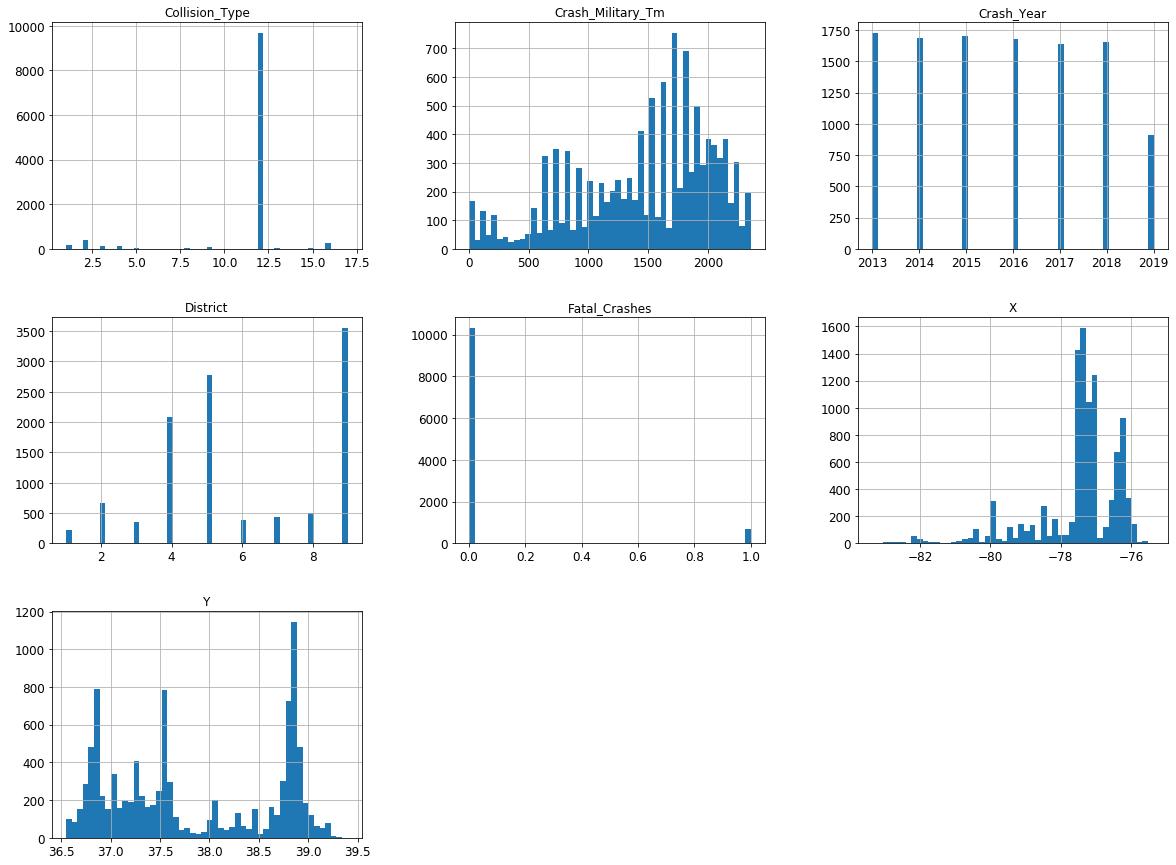

In [11]:
%matplotlib inline
accidents.hist(bins=50, figsize=(20,15))
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(accidents, test_size=0.2, random_state=42)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8799 entries, 8965 to 7270
Data columns (total 14 columns):
X                    8036 non-null float64
Y                    8036 non-null float64
Collision_Type       8799 non-null int64
Crash_Dt             8799 non-null object
Crash_Military_Tm    8799 non-null int64
Crash_Severity       8799 non-null object
Crash_Year           8799 non-null int64
District             8799 non-null int64
Fatal_Crashes        8799 non-null int64
Pedage               8627 non-null object
Pedgen               8799 non-null object
Pedinjurytype        8799 non-null object
Rte_Nm               8799 non-null object
Weather_Condition    8799 non-null object
dtypes: float64(2), int64(5), object(7)
memory usage: 1.0+ MB


# Step 3. Discover and Visualize the Data to Gain Insights

In [0]:
accidents = train_set.copy()

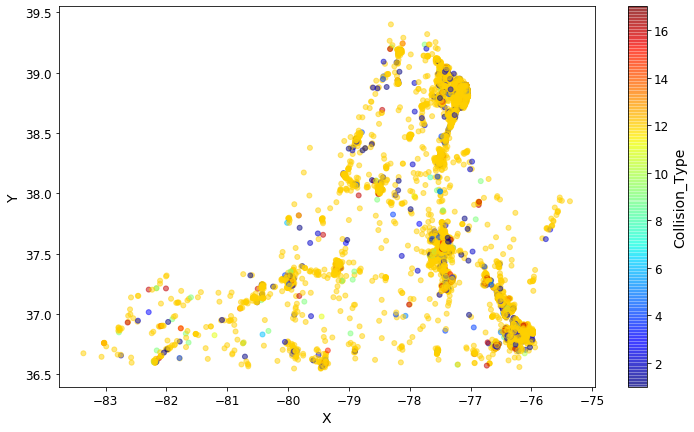

In [14]:
accidents.plot(kind="scatter", x="X", y="Y",
     c="Collision_Type", cmap=plt.get_cmap("jet"), 
     colorbar=True,s=25, alpha=0.5, figsize=(12,7),
     sharex=False)
plt.show()

In [0]:
corr_matrix = accidents.corr()

In [16]:
corr_matrix["Collision_Type"].sort_values(ascending=False)

Collision_Type       1.000000
Crash_Year           0.119662
Fatal_Crashes        0.013619
Y                    0.003124
District            -0.001605
Crash_Military_Tm   -0.003271
X                   -0.011177
Name: Collision_Type, dtype: float64

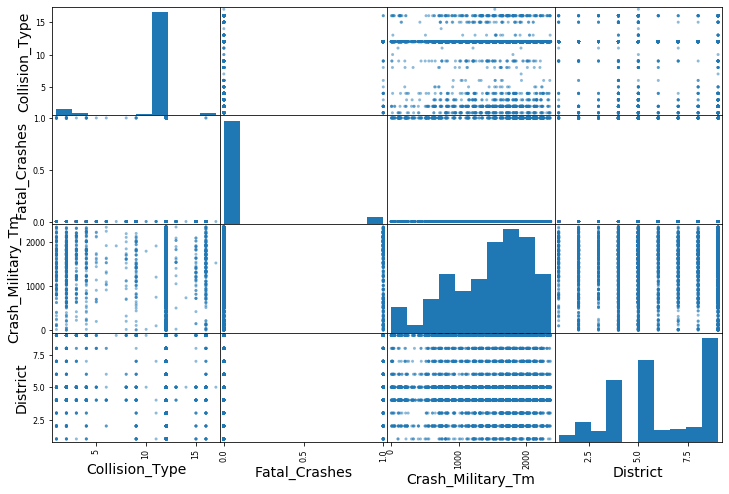

In [17]:
from pandas.plotting import scatter_matrix

attributes = ["Collision_Type","Fatal_Crashes",
              "Crash_Military_Tm", "District"]
scatter_matrix(accidents[attributes], figsize=(12, 8))
plt.show()

In [18]:
accidents.describe()

,X,Y,Collision_Type,Crash_Military_Tm,Crash_Year,District,Fatal_Crashes
count,8036.000000,8036.000000,8799.000000,8799.000000,8799.000000,8799.000000,8799.000000
mean,-77.479673,37.836071,11.297647,1464.122059,2015.773724,6.024435,0.060916
std,1.185898,0.836279,2.772569,573.681730,1.908110,2.425797,0.239190
min,-83.365154,36.545367,1.000000,0.000000,2013.000000,1.000000,0.000000
25%,-77.522155,37.043835,12.000000,1045.000000,2014.000000,4.000000,0.000000
50%,-77.313112,37.559622,12.000000,1611.000000,2016.000000,5.000000,0.000000
75%,-76.741950,38.804288,12.000000,1914.500000,2017.000000,9.000000,0.000000
max,-75.365792,39.400798,17.000000,2359.000000,2019.000000,9.000000,1.000000


# Step 4. Preparing the data for Machine Learning Algorithms (Data Cleaning)

In [0]:
# Create the features and labels for training
train_set = train_set.dropna()
accidents = train_set.drop("Collision_Type", axis=1) # drop labels for training set
accidents_labels = train_set["Collision_Type"].copy()

In [20]:
accidents.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7880 entries, 8965 to 7270
Data columns (total 13 columns):
X                    7880 non-null float64
Y                    7880 non-null float64
Crash_Dt             7880 non-null object
Crash_Military_Tm    7880 non-null int64
Crash_Severity       7880 non-null object
Crash_Year           7880 non-null int64
District             7880 non-null int64
Fatal_Crashes        7880 non-null int64
Pedage               7880 non-null object
Pedgen               7880 non-null object
Pedinjurytype        7880 non-null object
Rte_Nm               7880 non-null object
Weather_Condition    7880 non-null object
dtypes: float64(2), int64(4), object(7)
memory usage: 861.9+ KB


In [0]:
accidents_num = accidents.drop(["Crash_Severity","Crash_Dt","Pedage","Pedgen",
                                "Pedinjurytype","Rte_Nm","Weather_Condition"], axis=1)
accidents_cat = accidents[["Crash_Severity","Crash_Dt","Pedage","Pedgen",
                                "Pedinjurytype","Rte_Nm","Weather_Condition"]]

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler(with_mean=False)),
    ])

accidents_num_tr = num_pipeline.fit_transform(accidents_num)

In [23]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()

accidents_cat_1hot = cat_encoder.fit_transform(accidents_cat)
accidents_cat_1hot.toarray()

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [24]:
accidents.isnull().sum()

X                    0
Y                    0
Crash_Dt             0
Crash_Military_Tm    0
Crash_Severity       0
Crash_Year           0
District             0
Fatal_Crashes        0
Pedage               0
Pedgen               0
Pedinjurytype        0
Rte_Nm               0
Weather_Condition    0
dtype: int64

In [0]:
from sklearn.compose import ColumnTransformer

num_attribs = list(accidents_num)
cat_attribs = ["Crash_Severity","Crash_Dt","Pedage","Pedgen",
                                "Pedinjurytype","Rte_Nm","Weather_Condition"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

accidents_prepared = full_pipeline.fit_transform(accidents)

# Step 5. Select and Train a Model

## Train the Models

Linear Regression

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(accidents_prepared, accidents_labels)

accidents_predictions = lin_reg.predict(accidents_prepared)

lin_mse = mean_squared_error(accidents_labels, accidents_predictions)

lin_rmse = np.sqrt(lin_mse)
lin_rmse

1.5648317540764813

In [27]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(accidents_labels, accidents_predictions)

0.8331623168620522

In [0]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(lin_reg, accidents_prepared, accidents_labels,
                         scoring="neg_mean_squared_error", cv=3)
lin_rmse_scores = np.sqrt(-scores)

In [0]:
def display_scores(scores):
     print("Scores:", scores)
     print("Mean:", scores.mean())
     print("Standard deviation:", scores.std())

In [30]:
display_scores(lin_rmse_scores)

Scores: [4.20819022 4.39149565 4.70841668]
Mean: 4.4360341804757155
Standard deviation: 0.20663073350491812


Random Forest Regression

In [31]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(accidents_prepared, accidents_labels)

accidents_predictions = forest_reg.predict(accidents_prepared)
forest_mse = mean_squared_error(accidents_labels, accidents_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1.1080391630272057

In [0]:
forest_scores = cross_val_score(forest_reg, accidents_prepared, accidents_labels,
                                scoring="neg_mean_squared_error", cv=3)
forest_rmse_scores = np.sqrt(-forest_scores)

In [33]:
display_scores(forest_rmse_scores)

Scores: [2.89882472 3.01389188 2.99975565]
Mean: 2.9708240850980965
Standard deviation: 0.051237287050375314


K-Means Clustering

In [0]:
from sklearn.cluster import KMeans
X = accidents_prepared
y = accidents_labels
k = 22
kmeans = KMeans(n_clusters=k)
y_pred = kmeans.fit_predict(X)

In [92]:
kmeans.cluster_centers_

array([[-6.49879472e+01,  4.62989664e+01,  3.02854869e+00, ...,
         1.32450331e-03,  0.00000000e+00,  1.32450331e-03],
       [-6.46042226e+01,  4.45426167e+01,  1.36303326e+00, ...,
         0.00000000e+00,  0.00000000e+00,  5.42005420e-03],
       [-6.44729289e+01,  4.44569023e+01,  3.23506644e+00, ...,
         2.40963855e-03,  0.00000000e+00,  0.00000000e+00],
       ...,
       [-6.73641782e+01,  4.43163363e+01,  2.68323123e+00, ...,
         2.74725275e-03,  0.00000000e+00,  0.00000000e+00],
       [-6.43295589e+01,  4.43183109e+01,  2.67685546e+00, ...,
         0.00000000e+00,  0.00000000e+00,  1.93423598e-03],
       [-6.50880103e+01,  4.62498884e+01,  2.74253140e+00, ...,
         5.36193029e-03,  0.00000000e+00,  2.68096515e-03]])

In [93]:
accidents_predictions = kmeans.predict(accidents_prepared)
kmeans_mse = mean_squared_error(accidents_labels, accidents_predictions)
kmeans_rmse = np.sqrt(kmeans_mse)
kmeans_rmse

6.879907108923141

In [0]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

In [0]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_plot")
plt.show()

Linear SVM

In [37]:
from sklearn.svm import LinearSVC

X = accidents_prepared
y = accidents_labels

svm_clf = Pipeline([
        ("scaler", StandardScaler(with_mean=False)),
        ("linear_svc", LinearSVC(C=1, loss="hinge")),
    ])

svm_clf.fit(X, y)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=False, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [38]:
accidents_predictions = svm_clf.predict(accidents_prepared)

svm_clf_mse = mean_squared_error(accidents_labels, accidents_predictions)
svm_clf_rmse = np.sqrt(svm_clf_mse)
svm_clf_rmse

1.3831381225278434

In [39]:
svm_clf_scores = cross_val_score(svm_clf, accidents_prepared, accidents_labels,
                                scoring="neg_mean_squared_error", cv=3)
svm_clf_rmse_scores = np.sqrt(-forest_scores)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [40]:
display_scores(svm_clf_rmse_scores)

Scores: [2.89882472 3.01389188 2.99975565]
Mean: 2.9708240850980965
Standard deviation: 0.051237287050375314


Stochastic Gradient Descent (Binary Classifier for 12. Ped)

In [0]:
# y_train_12 = (accidents_labels == 12)  # True for all 5s, False for all other digits
# y_test_12 = (accidents_labels == 12)

# from sklearn.linear_model import SGDClassifier

# sgd_clf = SGDClassifier(random_state=42)
# sgd_clf.fit(accidents_prepared, y_train_12)

In [0]:
# from sklearn.model_selection import cross_val_score
# cross_val_score(sgd_clf, accidents_prepared, y_train_12, cv=3, scoring="accuracy")

Decision Tree Regressor

In [43]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(accidents_prepared, accidents_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [44]:
accidents_predictions = tree_reg.predict(accidents_prepared)
tree_mse = mean_squared_error(accidents_labels, accidents_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [45]:
scores = cross_val_score(tree_reg, accidents_prepared, accidents_labels,
                         scoring="neg_mean_squared_error", cv=3)
tree_rmse_scores = np.sqrt(-scores)
display_scores(tree_rmse_scores)

Scores: [3.52774635 3.55510217 3.66650511]
Mean: 3.583117874678166
Standard deviation: 0.06001198941445613


## Tuning the Hyperparameters

Random Forest Regression

In [46]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [75,100,150], 'max_features': [2, 4, 6]},
  ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=3,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(accidents_prepared, accidents_labels)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                             max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators='warn', n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'max_features': [2, 4, 6],
   

In [47]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 150}

In [48]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=6, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [49]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(np.sqrt(-mean_score), params)

2.765240163435668 {'max_features': 2, 'n_estimators': 75}
2.749757829302986 {'max_features': 2, 'n_estimators': 100}
2.751651951222163 {'max_features': 2, 'n_estimators': 150}
2.7600307182543893 {'max_features': 4, 'n_estimators': 75}
2.7548799191981646 {'max_features': 4, 'n_estimators': 100}
2.75232202741307 {'max_features': 4, 'n_estimators': 150}
2.761457575510143 {'max_features': 6, 'n_estimators': 75}
2.7621256149384963 {'max_features': 6, 'n_estimators': 100}
2.7490560680658063 {'max_features': 6, 'n_estimators': 150}


In [50]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([5.23617468e-02, 5.38221292e-02, 5.13524735e-02, ...,
       8.28110039e-04, 3.31397519e-06, 2.84230889e-04])

In [51]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_attribs
# print(attributes)
# print(cat_attribs)
sorted(zip(feature_importances, attributes), reverse=True)

[(0.05382212917203509, 'Y'),
 (0.05236174676802504, 'X'),
 (0.051352473522800576, 'Crash_Military_Tm'),
 (0.03441455991290808, 'Crash_Year'),
 (0.022567936266365902, 'District'),
 (0.008087440994506093, 'Crash_Dt'),
 (0.007000795857103864, 'Crash_Severity'),
 (0.005821000953398187, 'Pedage'),
 (0.0019432019593524836, 'Pedgen'),
 (0.0016732515566892144, 'Fatal_Crashes'),
 (0.0009446041235914831, 'Rte_Nm'),
 (0.0001620676783639874, 'Weather_Condition'),
 (3.7522659252828425e-05, 'Pedinjurytype')]